Type I Equilibrium Plots

In [6]:
import numpy as np
import matplotlib.pyplot as plt
final_fig_path = "../Manuscript/Figures/"
import sys
sys.path.insert(1, 'Functions')
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from scipy.integrate import solve_ivp
from sim_graph_funs import *
from scipy.optimize import fsolve, minimize, root

In [7]:
H=0
x_max = 10
params_base = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 8, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, ξ = 2, d = 10,
                 Tx = .01, r = 0, γ = 0, pop_process = True)

In [3]:
P0 = 3
xvec = np.arange(1,11,1)
F0 = np.zeros(x_max) + P0/x_max
F0 = F0/xvec

In [36]:
plot_portion_x?

Signature: plot_portion_x(fig, ax, out, x_max, xlim=[-1, 500])
Docstring:
plots time vs x*F(x)
@inputs
ax is the axis that is already made
out is the output of solve_ivp

@ returns: fig, ax
File:      /var/folders/qd/9pxy4gkx37575w3vclv1xfk40000gp/T/ipykernel_42773/987304471.py
Type:      function

3000.0


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$T$, Scaled time', ylabel='$xF(x)/P$'>)

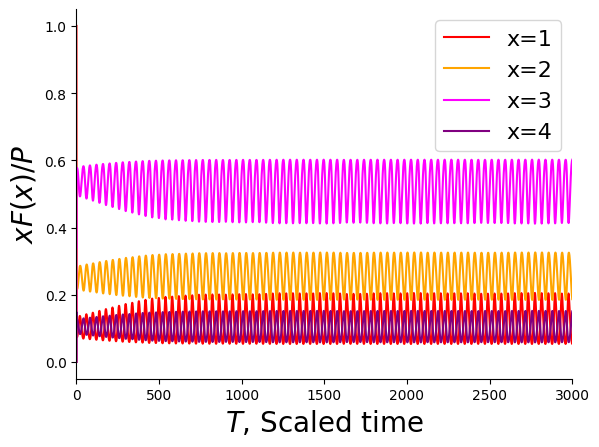

In [37]:
fig, ax = plt.subplots(1,1)
plot_portion_x(fig, ax, out2, x_max=10, xlim = [-1,3000])

In [31]:
plot_all?

Signature: plot_all(T, N1, N2, P, mean_x, xlim=[-10, 600])
Docstring: <no docstring>
File:      ~/Documents/CH_pop_dyn/Code_CH_popdyn/Functions/sim_graph_funs.py
Type:      function

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$T$, Scaled time'>)

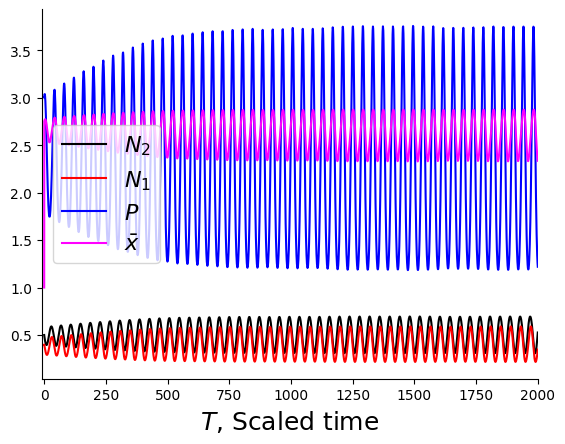

In [38]:
plot_all(T,N1,N2,P,mean_x, xlim = [-10, 2000])

In [4]:
xvec = np.arange(1,x_max+1,1)
β1vec = np.arange(1,10,0.2)
Pvec = np.zeros(len(β1vec))
meanxvec = np.zeros(len(β1vec))
Fxvecs  = np.zeros((len(β1vec), x_max))
N1vec = Pvec.copy()
N2vec = Pvec.copy()

for i, β1 in enumerate(β1vec):
    params = params_base.copy()
    params['β1'] = β1
    initialstate = np.array([3, 0.5, 0.5, 3, *np.zeros(9)])
    t_f = 2000
    out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
    T,N1,N2,P,Fxvec, mean_x = get_results(out2, 10)
    #N1_eq, N2_eq, F_eq, P_eq, mean_x_eq = get_equilibrium(params)
    Fxvecs[i,:] = Fxvec[:,-1]
    Pvec[i] = P[-1]
    N1vec[i] = N1[-1]
    N2vec[i] = N2[-1]
    meanxvec[i] = mean_x[-1]
    

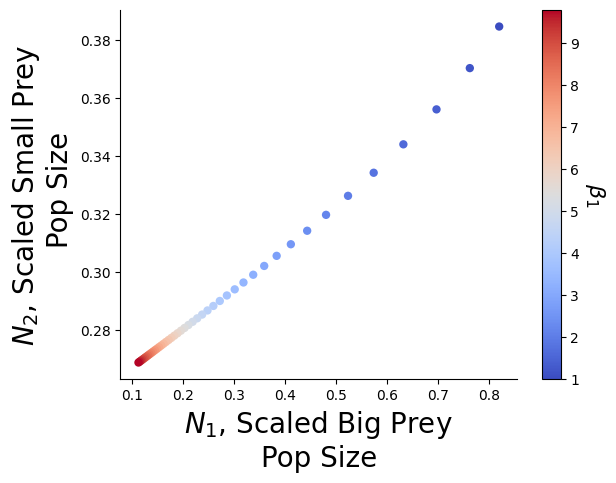

In [5]:
fig, ax = plt.subplots(1,1)
p = plt.scatter(N1vec,N2vec, c = β1vec, cmap = 'coolwarm', edgecolor='none')
cb = plt.colorbar(p, label = β1lab)
cb.set_label(label=β1lab, rotation = 270, fontsize = 16, labelpad = 20)
#plt.plot(N1vec,N2vec, 'k')
format_ax(ax,N1lab,N2lab)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\beta_1$', ylabel='Freq$(x)$'>)

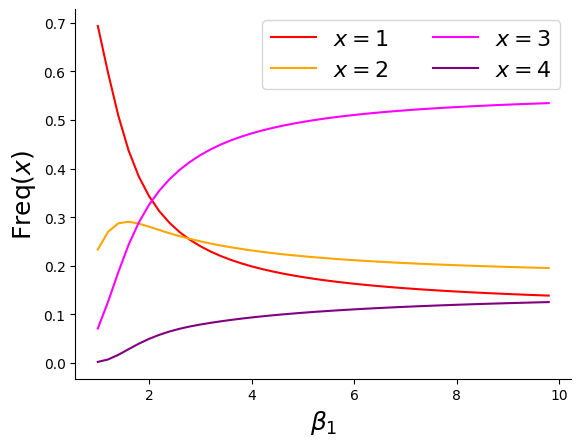

In [12]:
freq_x_lab = r'Freq$(x)$'
plot_freq_x_eq(β1vec, Fxvecs, xvec, Pvec, β1lab, 
                       ncol_legend = 2,
                       )

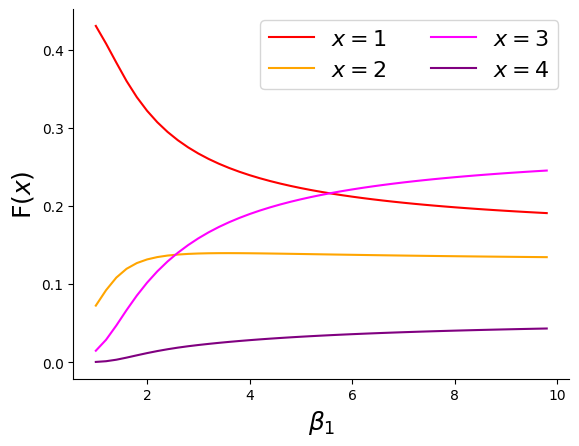

In [13]:
fig,ax = plot_F_equilibrium(β1vec, Fxvecs, xvec, β1lab, Fxlab, ncol_legend=2)

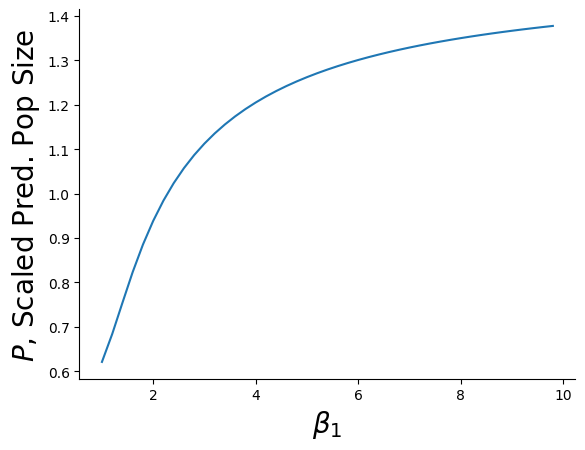

In [17]:
fig,ax = plt.subplots(1,1)
plt.plot(β1vec, Pvec)
format_ax(ax,β1lab,Plab)

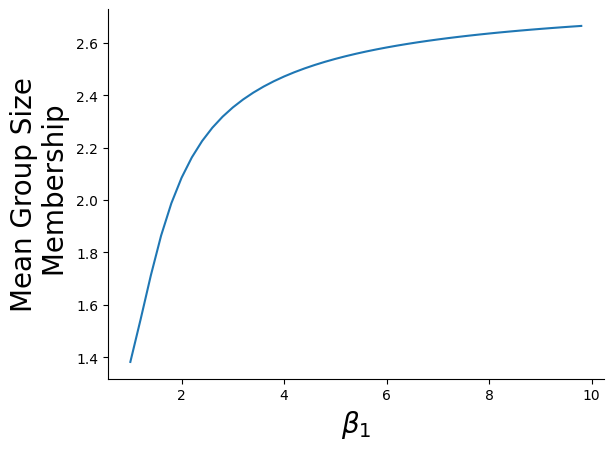

In [18]:
fig,ax = plt.subplots(1,1)
plt.plot(β1vec, meanxvec)
format_ax(ax,β1lab,mean_x_lab)